변수 계산 및 신규 데이터 저장 코드

In [4]:
import pandas as pd

# 파일 경로
file_general = "C:\\Users\\m\\Desktop\\변수 생성용 데이터\\서울시_상권분석_서비스_컬럼제거.csv"
file_sales = "C:\\Users\\m\\Desktop\\변수 생성용 데이터\\서울시_상권분석_서비스_매출추가_매출결측치_제거.csv"

# 데이터 로드
df_general = pd.read_csv(file_general)
df_sales = pd.read_csv(file_sales)

# 4개 분기(1년) 단위로 이동 표준 편차 및 증감률 계산
rolling_window = 4

# 유동인구 안정성
df_sales['유동인구_안정성'] = df_sales.groupby(['상권명', '업종명'])['유동인구수'].transform(lambda x: x.mean() / (x.std() + 1))

# 점포 수 변동성
df_general['점포_수_변동성'] = df_general.groupby(['상권명', '업종명'])['점포_수'].transform(lambda x: x.rolling(rolling_window).std())

# 점포 수 증감률
df_general['점포_수_증감률'] = df_general.groupby(['상권명', '업종명'])['점포_수'].transform(lambda x: x.pct_change(periods=rolling_window))

# 매출 관련 변수 생성
if '매출_금액' in df_sales.columns:
    df_sales['매출_변동성'] = df_sales.groupby(['상권명', '업종명'])['매출_금액'].transform(lambda x: x.rolling(rolling_window).std())
    df_sales['매출_증감률'] = df_sales.groupby(['상권명', '업종명'])['매출_금액'].transform(lambda x: x.pct_change(periods=rolling_window))
    df_sales['매출_안정성'] = df_sales.groupby(['상권명', '업종명'])['매출_금액'].transform(lambda x: x.median() / (x.std() + 1))
    df_sales['매출_감소율'] = df_sales.groupby(['상권명', '업종명'])['매출_금액'].transform(lambda x: (x.shift(rolling_window) - x) / (x.shift(rolling_window) + 1))
    df_sales['소비_전환율'] = df_sales['매출_금액'] / (df_sales['유동인구수'] + 1)

# 개폐업 관련 변수 생성
if '개업_점포_수' in df_general.columns and '폐업_점포_수' in df_general.columns:
    df_general['개폐업_비율'] = df_general['폐업_점포_수'] / (df_general['개업_점포_수'] + 1)
    df_general['개폐업_균형_지수'] = (df_general['개업_점포_수'] - df_general['폐업_점포_수']) / (df_general['개업_점포_수'] + df_general['폐업_점포_수'] + 1) * 100

# 프랜차이즈 관련 변수 생성
if '프랜차이즈_점포_수' in df_general.columns and '점포_수' in df_general.columns:
    df_general['프랜차이즈_비율'] = df_general['프랜차이즈_점포_수'] / df_general['점포_수']
    df_general['프랜차이즈_변동성'] = df_general.groupby(['상권명', '업종명'])['프랜차이즈_점포_수'].transform(lambda x: x.rolling(rolling_window).std())

# 영업 개월 차이
df_general['영업_개월_차이'] = df_general.groupby(['상권명', '업종명']).apply(lambda x: x['서울_운영_영업_개월_평균'].rolling(rolling_window).mean() - x['서울_폐업_영업_개월_평균'].rolling(rolling_window).mean()).reset_index(level=[0,1], drop=True)

# 점포 생존율
if '점포_수' in df_general.columns and '폐업_점포_수' in df_general.columns:
    df_general['점포_생존율'] = 1 - (df_general['폐업_점포_수'] / df_general['점포_수'])

# 유사업종 경쟁 강도
if '유사_업종_점포_수' in df_general.columns and '점포_수' in df_general.columns:
    df_general['유사_업종_경쟁_강도'] = df_general['유사_업종_점포_수'] / df_general['점포_수']

df_general["점포_증감률"] = df_general.groupby(["상권명", "업종명"])["점포_수"].transform(lambda x: (x - x.shift(1)) / (x.shift(1) + 1) * 100)

# 데이터 저장
df_general.to_csv("C:\\Users\\m\\Desktop\\변수 생성용 데이터\\서울시_상권분석_서비스_일반변수.csv", index=False)
df_sales.to_csv("C:\\Users\\m\\Desktop\\변수 생성용 데이터\\서울시_상권분석_서비스_매출변수.csv", index=False)

print("변수 생성 완료: 일반 변수(df_general)와 매출 변수(df_sales) 각각 저장됨.")

C:\Users\m\AppData\Local\Temp\ipykernel_3212\796764776.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_general['영업_개월_차이'] = df_general.groupby(['상권명', '업종명']).apply(lambda x: x['서울_운영_영업_개월_평균'].rolling(rolling_window).mean() - x['서울_폐업_영업_개월_평균'].rolling(rolling_window).mean()).reset_index(level=[0,1], drop=True)


변수 생성 완료: 일반 변수(df_general)와 매출 변수(df_sales) 각각 저장됨.


1️⃣ 📂 서울시_상권분석_서비스_매출추가_결과.csv
(매출 데이터를 포함한 파일 → df_sales)

- 매출 변동성

4개 분기 매출의 표준편차

- 매출 증감률

(현재 분기의 매출 - 4개 분기 전의 매출) / 4개 분기 전의 매출

* 매출 안정성 (매출_안정성)

매출 금액의 중위값을 표준편차로 나눈 값으로, 매출 변동성을 고려한 안정성 지표.
계산식: 매출_금액의 중위값 / (표준편차 + 1)


- 매출 감소율 (매출_감소율)

이전 분기 대비 현재 분기의 매출 감소 비율을 나타냄.
계산식: (이전 분기 매출 - 현재 분기 매출) / (이전 분기 매출 + 1)
groupby(['상권명', '업종명'])을 이용해 분기별로 변화량 계산.

* 소비 전환율 (소비_전환율)

유동인구 대비 실제 매출이 발생하는 비율을 나타냄.
계산식: 매출_금액 / (유동인구수 + 1)

* 유동인구 안정성 (유동인구_안정성)

유동인구의 평균값을 표준편차로 나눈 값으로, 유동인구 변동성을 고려한 안정성 지표.
계산식: 유동인구수의 평균 / (표준편차 + 1)

2️⃣ 📂 서울시_상권분석_서비스_컬럼제거_결과.csv
(일반적인 상권 데이터 → df_general)

추가된 변수

- 점포 수 변동성 (점포_수_변동성)

각 상권의 점포 수 변동성을 반영하기 위해 이전 분기 대비 표준편차를 계산.
계산식: 점포_수의 rolling std()

* 개폐업 비율 (개폐업_비율)

폐업 점포 수를 개업 점포 수로 나눈 값으로, 상권 내 점포 변화 정도를 평가.
계산식: 폐업_점포_수 / (개업_점포_수 + 1)

* 개폐업 균형 지수 (개폐업_균형_지수)

개업과 폐업 간의 균형을 측정하는 지표.
계산식: (개업_점포_수 - 폐업_점포_수) / (개업_점포_수 + 폐업_점포_수 + 1) * 100
양수면 개업이 많고, 음수면 폐업이 많음을 의미.

- 프랜차이즈 비율 (프랜차이즈_비율)

전체 점포 중 프랜차이즈 점포가 차지하는 비율을 나타냄.
계산식: 프랜차이즈_점포_수 / 점포_수

- 프랜차이즈 변동성 (프랜차이즈_변동성)

프랜차이즈 점포 수의 변동성을 평가하기 위해 rolling std() 계산.
계산식: 프랜차이즈_점포_수의 rolling std()

* 영업 개월 차이 (영업_개월_차이)

운영 중인 점포의 평균 영업 개월 수와 폐업한 점포의 평균 영업 개월 수 차이.
계산식: 영업_개월_평균 - 폐업_영업_개월_평균
값이 크면 기존 점포들이 오래 운영되었다는 의미.

* 점포 증감률 (점포_증감률)

이전 분기 대비 점포 수 증가율을 나타냄.
계산식: (점포_수 - 이전 분기 점포 수) / 이전 분기 점포 수 * 100
값이 크면 점포가 많이 늘어나고 있다는 의미.

* 점포 생존율 (점포_생존율)

폐업 점포 수를 고려한 전체 점포 생존 비율.
계산식: 1 - (폐업_점포_수 / 점포_수)
1에 가까울수록 점포가 유지되는 비율이 높음.

* 유사업종 경쟁 강도 (유사업종_경쟁_강도)

특정 상권 내 같은 업종의 점포 비율을 나타냄.
계산식: 유사 업종 점포 수 / 점포 수
값이 높을수록 특정 업종에 대한 경쟁이 치열함을 의미.

매출 변수 파일 확인 결과 : 매출 변동성, 매출 증감률, 매출 감소율열에서 간혹 null값이 발견됨. 분석시 null값을 제외하고 분석하도록 해야 할듯. 매출 증감률, 매출 감소율열 20223, 20193분기에서 null 자주 발생. 매출 변동성열 20192분기까지 null.

일반 변수 파일 확인 결과 : 점포 수 변동성, 프랜차이즈 변동성 열에서 20192분기까지 null. 점포 수 증감률 열에서 20193분기까지 null 다수. 프랜차이즈 비율 열에서 일부 값 inf로 출력됨.

상관계수 분석

In [ ]:
import pandas as pd

# 파일 경로
file_general = "C:\\Users\\m\\Desktop\\변수 생성용 데이터\\서울시_상권분석_서비스_일반변수.csv"
file_sales = "C:\\Users\\m\\Desktop\\변수 생성용 데이터\\서울시_상권분석_서비스_매출변수.csv"

# 데이터 로드
df_general = pd.read_csv(file_general)
df_sales = pd.read_csv(file_sales)

# 필요한 컬럼만 선택
selected_columns = [
    "매출_안정성", "소비_전환율", "유동인구_안정성",
    "개폐업_비율", "개폐업_균형_지수", "영업_개월_차이",
    "점포_증감률", "점포_생존율", "유사_
    업종_경쟁_강도"
]

# 데이터 병합 (공통된 키: 연분기, 상권명, 업종명)
df_merged = pd.merge(df_general, df_sales, on=["연분기", "상권명", "업종명"], how="inner")

# 선택한 컬럼만 필터링
df_selected = df_merged[selected_columns]

# 상관계수 계산
correlation_matrix = df_selected.corr()

# 상관계수 출력
print(correlation_matrix)

               매출_안정성    소비_전환율  유동인구_안정성    개폐업_비율  개폐업_균형_지수  영업_개월_차이  \
매출_안정성       1.000000  0.001468  0.001371 -0.005634   0.000500  0.003422   
소비_전환율       0.001468  1.000000 -0.001270 -0.001090  -0.000338  0.003432   
유동인구_안정성     0.001371 -0.001270  1.000000  0.002101   0.013247  0.021076   
개폐업_비율      -0.005634 -0.001090  0.002101  1.000000  -0.583075  0.017894   
개폐업_균형_지수    0.000500 -0.000338  0.013247 -0.583075   1.000000 -0.027094   
영업_개월_차이     0.003422  0.003432  0.021076  0.017894  -0.027094  1.000000   
점포_증감률       0.001052 -0.000518  0.024857 -0.116838   0.284213  0.009570   
점포_생존율       0.004716  0.000936 -0.000786 -0.414619   0.374895 -0.000105   
유사_업종_경쟁_강도 -0.002086 -0.000581  0.003802  0.017075  -0.002430 -0.006245   

               점포_증감률    점포_생존율  유사_업종_경쟁_강도  
매출_안정성       0.001052  0.004716    -0.002086  
소비_전환율      -0.000518  0.000936    -0.000581  
유동인구_안정성     0.024857 -0.000786     0.003802  
개폐업_비율      -0.116838 -0.414619     0.017075  
개폐업_

In [14]:
import pandas as pd

# 데이터 불러오기
file_general = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_일반변수.csv"
file_sales = r"C:\Users\m\Desktop\변수 생성용 데이터\서울시_상권분석_서비스_매출변수.csv"

df_general = pd.read_csv(file_general, encoding="utf-8")
df_sales = pd.read_csv(file_sales, encoding="utf-8")

# 병합 (중복 컬럼 제거)
df = pd.merge(df_general, df_sales, on=["연분기", "상권명", "업종명"], how="inner")

# _x, _y로 중복된 컬럼 처리 (일반적으로 동일한 데이터이므로 하나만 유지)
for col in df.columns:
    if col.endswith("_x"):  # "_x"가 붙은 컬럼만 확인
        base_col = col[:-2]  # "_x" 제거
        if base_col + "_y" in df.columns:  # 동일한 _y 컬럼이 있으면 삭제
            df.drop(columns=[base_col + "_y"], inplace=True)
        df.rename(columns={col: base_col}, inplace=True)  # _x를 원래 이름으로 변경

# 컬럼명 확인
print(df.columns)

Index(['연분기', '상권명', '업종명', '점포_수', '유사_업종_점포_수', '개업율', '개업_점포_수', '폐업률',
       '폐업_점포_수', '프랜차이즈_점포_수', '자치구명', '서울_운영_영업_개월_평균', '서울_폐업_영업_개월_평균',
       '점포_수_변동성', '점포_수_증감률', '개폐업_비율', '개폐업_균형_지수', '프랜차이즈_비율', '프랜차이즈_변동성',
       '영업_개월_차이', '점포_생존율', '유사_업종_경쟁_강도', '점포_증감률', '매출_금액', '매출_건수',
       '유동인구수', '유동인구_안정성', '매출_변동성', '매출_증감률', '매출_안정성', '매출_감소율', '소비_전환율'],
      dtype='object')


c:\Users\m\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


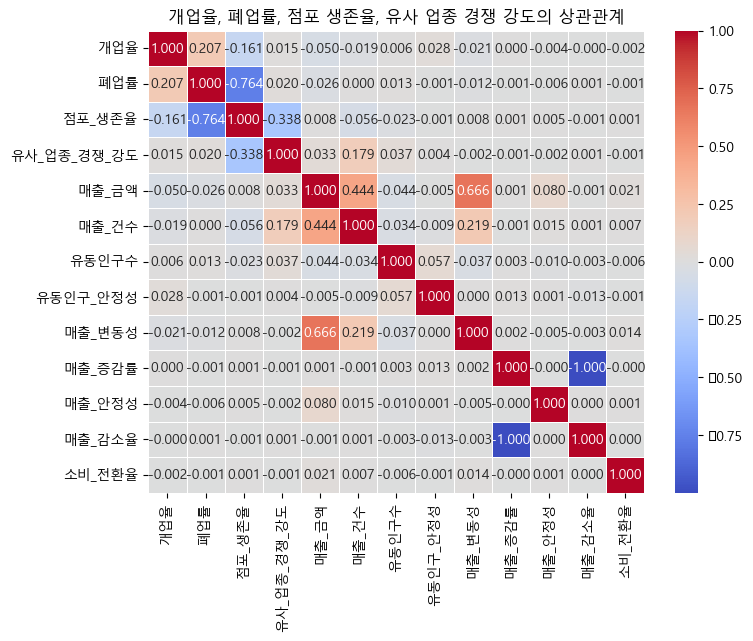

In [18]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rc("font", family="Malgun Gothic")

# 사용할 변수 선택
selected_cols = [
    "개업율", "폐업률", "점포_생존율", "유사_업종_경쟁_강도", "매출_금액", "매출_건수", "유동인구수", "유동인구_안정성", "매출_변동성", "매출_증감률", "매출_안정성", "매출_감소율", "소비_전환율"
]
df_selected = df[selected_cols]

# 상관관계 계산
corr_matrix = df_selected.corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
plt.title("개업율, 폐업률, 점포 생존율, 유사 업종 경쟁 강도의 상관관계")
plt.show()